In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


/cs/labs/mornitzan/nomoriel/miniconda3/envs/p2vd/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


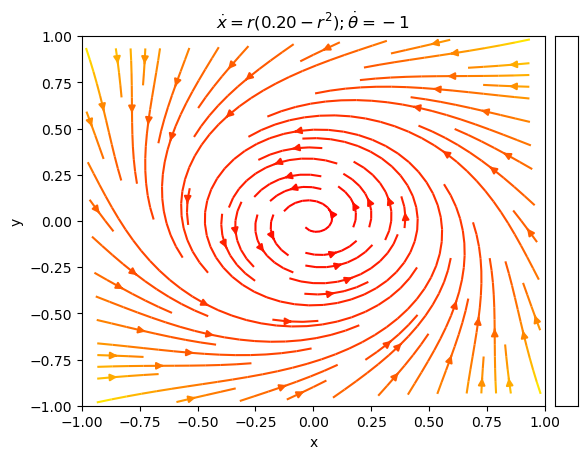

In [2]:
import phase2vec as p2v
params = [0.2]
device = 'cpu'
DE = p2v.dt.SimpleOscillator(params, device=device)
DE.plot_trajectory()
coords = DE.coords_xy
z = coords.reshape(-1, 2)




In [3]:
# construct a model
nlayers = 1

# RealNVP
# flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(nlayers)]
flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(nlayers)]#(4)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(nlayers)]#(4)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# Neural splines, coupling
# nfs_flow = NSF_CL if True else NSF_AR
# flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=2) for _ in range(nlayers)] # 3
# convs = [Invertible1x1Conv(dim=2) for _ in flows]
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlow(flows)

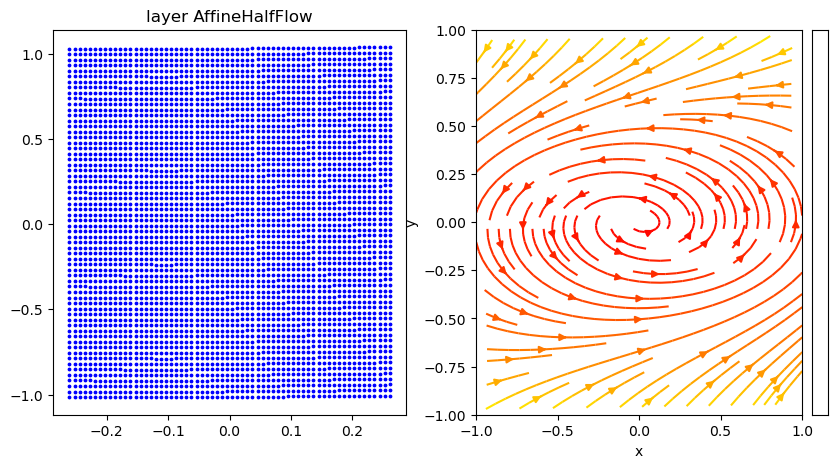

In [4]:

# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 64
xy = z
in_circle = np.sqrt((xy**2).sum(axis=1)) <= 3 # seems appropriate since we use radial distributions as priors
zs, log_det = model.backward(xy)

backward_flow_names = [type(f).__name__ for f in model.flows[::-1]]
z0 = zs[0].detach().numpy()
z1 = zs[-1].detach().numpy()

# plot how the samples travel at this stage
figs, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
axs[1].axis([-1, 1, -1, 1])
axs[0].set_title("layer %s" % (backward_flow_names[-1]))

vectors_warped = DE.forward(0, z=torch.tensor(z1))
vectors_new = vectors_warped #model.backward(vectors_warped)[0][-1]
vectors_new = vectors_new.detach().numpy().reshape(coords.shape)
coords, vectors = DE.get_vector_field()
p2v.dt.FlowSystemODE.plot_trajectory_2d(coords=coords, vectors=vectors_new, ax=axs[1])